Analyzing IPL data from 2008 to 2019. 
Motivation for this is to answer below questions: 
Which is the best performing team in IPL history, based on total number of titles and matches won?
How toss affects the outcome of the game?
Which overs are best to score runs and which ones give most number of wickets for bowlers?

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#import csv files
matches_df = pd.read_csv("matches.csv")
deliveries_df = pd.read_csv("deliveries.csv")


#Cleaning Matches data
#questions we want to answer are not related to Umpires so we can delete umpire columns
#there is some datatype issue as well so lets see what all we need to change in the data

In [3]:
matches_df.info()
matches_df = matches_df.sort_values(['season', 'id'], ascending = (True, True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               756 non-null    int64 
 1   season           756 non-null    int64 
 2   city             749 non-null    object
 3   date             756 non-null    object
 4   team1            756 non-null    object
 5   team2            756 non-null    object
 6   toss_winner      756 non-null    object
 7   toss_decision    756 non-null    object
 8   result           756 non-null    object
 9   dl_applied       756 non-null    int64 
 10  winner           752 non-null    object
 11  win_by_runs      756 non-null    int64 
 12  win_by_wickets   756 non-null    int64 
 13  player_of_match  752 non-null    object
 14  venue            756 non-null    object
 15  umpire1          754 non-null    object
 16  umpire2          754 non-null    object
 17  umpire3          119 non-null    ob

In [4]:
#Clearly we can delete Umpire columns
#There is date column which is of the type object, changing the datatype to datetime
matches_df = matches_df.drop(['umpire1', 'umpire2', 'umpire3'], axis = 1)
matches_df['date'] = matches_df['date'].astype('datetime64')

In [5]:
#we can see there are only 4 missing values in winner and player of match , and 7 in city. we will see how best we can fill these missing value.
matches_df[matches_df.isnull().any(axis=1)]

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue
300,301,2011,Delhi,2011-05-21,Delhi Daredevils,Pune Warriors,Delhi Daredevils,bat,no result,0,NaN,0,0,NaN,Feroz Shah Kotla
461,462,2014,NaN,2014-04-19,Mumbai Indians,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Royal Challengers Bangalore,0,7,PA Patel,Dubai International Cricket Stadium
462,463,2014,NaN,2014-04-19,Kolkata Knight Riders,Delhi Daredevils,Kolkata Knight Riders,bat,normal,0,Delhi Daredevils,0,4,JP Duminy,Dubai International Cricket Stadium
466,467,2014,NaN,2014-04-23,Chennai Super Kings,Rajasthan Royals,Rajasthan Royals,field,normal,0,Chennai Super Kings,7,0,RA Jadeja,Dubai International Cricket Stadium
468,469,2014,NaN,2014-04-25,Sunrisers Hyderabad,Delhi Daredevils,Sunrisers Hyderabad,bat,normal,0,Sunrisers Hyderabad,4,0,AJ Finch,Dubai International Cricket Stadium
469,470,2014,NaN,2014-04-25,Mumbai Indians,Chennai Super Kings,Mumbai Indians,bat,normal,0,Chennai Super Kings,0,7,MM Sharma,Dubai International Cricket Stadium
474,475,2014,NaN,2014-04-28,Royal Challengers Bangalore,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,5,Sandeep Sharma,Dubai International Cricket Stadium
476,477,2014,NaN,2014-04-30,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Sunrisers Hyderabad,15,0,B Kumar,Dubai International Cricket Stadium
545,546,2015,Bangalore,2015-04-29,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,no result,0,NaN,0,0,NaN,M Chinnaswamy Stadium
570,571,2015,Bangalore,2015-05-17,Delhi Daredevils,Royal Challengers Bangalore,Royal Challengers Bangalore,field,no result,0,NaN,0,0,NaN,M Chinnaswamy Stadium


In [6]:
#in case of winner and player of match columns null value is for matches where there was no result, impumting these null value by "No result"
#we will delete city coulmn as well
matches_df = matches_df.drop(['city'], axis = 1)
matches_df['winner'].fillna("No result", inplace = True)
matches_df['player_of_match'].fillna("No result", inplace = True)


In [7]:
#A lot of franchises were renamed and dissaolved during the course of 12 years. Lets see which team names are present in the data set.
#we will rename the teams with the longest used names for consistency
matches_df['team1'].nunique()


15

In [8]:
#we have 15 unique team names in data set.
#Delhi Daredevils and Delhi Capitals are from same city "Delhi", we will consider them as 1 franchise and rename Delhi Capitals as Delhi Daredevils
#Sunrisers Hyderabad and Decan Chargers are from same city "Delhi", we will consider them as 1 franchise and rename Decan Chargers as Sunrisers Hyderabad
#Pune Warriors, Rising Pune Supergiant and Rising Pune Supergiants are from same city , we will name them as Rising Pune Supergiants
matches_df.replace("Delhi Capitals", "Delhi Daredevils", inplace = True)
matches_df.replace(to_replace = "Deccan Chargers", value = "Sunrisers Hyderabad", inplace = True)
matches_df.replace("Rising Pune Supergiant", "Rising Pune Supergiants", inplace = True)
matches_df.replace("Pune Warriors", "Rising Pune Supergiants", inplace = True)

#Cleaning deliveries data
#questions we want to answer are not related to Umpires so we can delete umpire columns
#there is some datatype issue as well so lets see what all we need to change in the data

In [9]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179078 entries, 0 to 179077
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          179078 non-null  int64 
 1   inning            179078 non-null  int64 
 2   batting_team      179078 non-null  object
 3   bowling_team      179078 non-null  object
 4   over              179078 non-null  int64 
 5   ball              179078 non-null  int64 
 6   batsman           179078 non-null  object
 7   non_striker       179078 non-null  object
 8   bowler            179078 non-null  object
 9   is_super_over     179078 non-null  int64 
 10  wide_runs         179078 non-null  int64 
 11  bye_runs          179078 non-null  int64 
 12  legbye_runs       179078 non-null  int64 
 13  noball_runs       179078 non-null  int64 
 14  penalty_runs      179078 non-null  int64 
 15  batsman_runs      179078 non-null  int64 
 16  extra_runs        179078 non-null  int

In [10]:
#to treat null values in last three columns player_dismissed, dismissal kind and fielder, we will add N/A as these are instances where no wicket fell or if it did not fielder was involved like in cases of bowled or leg before wicket
deliveries_df['player_dismissed'].fillna("N/A", inplace= True)
deliveries_df['dismissal_kind'].fillna("N/A", inplace= True)
deliveries_df['fielder'].fillna("N/A", inplace= True)

In [11]:
#we have 15 unique team names in data set.
#Delhi Daredevils and Delhi Capitals are from same city "Delhi", we will consider them as 1 franchise and rename Delhi Capitals as Delhi Daredevils
#Sunrisers Hyderabad and Decan Chargers are from same city "Delhi", we will consider them as 1 franchise and rename Decan Chargers as Sunrisers Hyderabad
#Pune Warriors, Rising Pune Supergiant and Rising Pune Supergiants are from same city , we will name them as Rising Pune Supergiants
deliveries_df.replace("Delhi Capitals", "Delhi Daredevils", inplace = True)
deliveries_df.replace(to_replace = "Deccan Chargers", value = "Sunrisers Hyderabad", inplace = True)
deliveries_df.replace("Rising Pune Supergiant", "Rising Pune Supergiants", inplace = True)
deliveries_df.replace("Pune Warriors", "Rising Pune Supergiants", inplace = True)

Lets find which team played how many games in total and what was the win percentage for the team.

#Which is the best performing team in IPL history. There can be sevaral ways to answer this question, I am using the method 1. where the team which wins most number of games irrespective of titles is the best performing team, 2. Team with most number of titles
#To answer using first method we need to find the team which won most number of games.We can achieve that by doing a groupby and count on winner coulmn from matches dataframe


In [18]:
winners = matches_df.groupby(['winner'])['winner'].count()
label_winners = np.sort(matches_df['winner'].unique())
winners
label_winners

array(['Chennai Super Kings', 'Delhi Daredevils', 'Gujarat Lions',
       'Kings XI Punjab', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders',
       'Mumbai Indians', 'No result', 'Rajasthan Royals',
       'Rising Pune Supergiants', 'Royal Challengers Bangalore',
       'Sunrisers Hyderabad'], dtype=object)

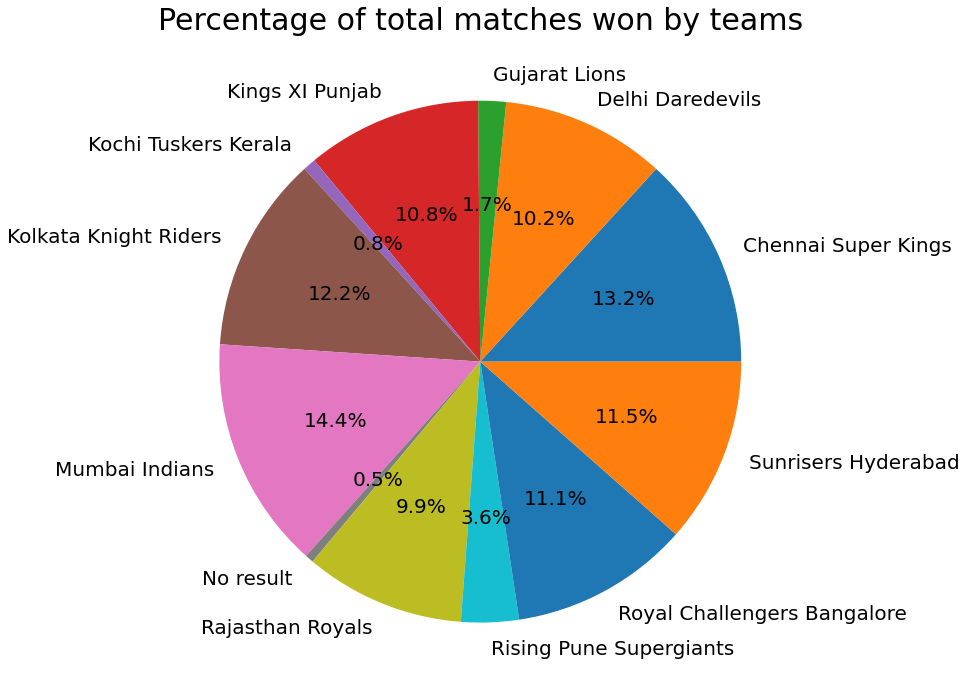

In [19]:
fig, ax = plt.subplots(figsize = (12,12))
ax.pie(winners, labels=list(label_winners), autopct='%1.1f%%')
ax.set_title('Percentage of total matches won by teams')
plt.rc('axes', titlesize=30, labelsize=20)
plt.rc('font', size=20)

Clearly Mumbai Indian have won most number of games in IPL history followed by Chennai super kings and Kolata Knight Riders
Now lets calculate the number of titles won by teams and chart it.
Lat match of each season in the final game, winner of final game is pronounced as champion/title holder. 

In [21]:
#lets find the last game of each season and take out then name of winner 
winners_df = matches_df.groupby('season').nth([-1])
title_winners = winners_df.groupby(['winner'])['winner'].count()
title_winners

winner
Chennai Super Kings      3
Kolkata Knight Riders    2
Mumbai Indians           4
Rajasthan Royals         1
Sunrisers Hyderabad      2
Name: winner, dtype: int64

Here we can see Mumbai Indians have won most number of titles also followed by Chennai super kings. #clearly Mumbai Indians comes out to be a supirior team franchise here as well with 4 title wins.
IPL has seen many ups and downs in last 12 year several team played only for few seasons and 2 team (Chennai super kings and Rajasthan Royals) were banned for 2 seasons. Given this information, the criteria of total number of wins in IPL wont be a good indicator as teams have palyed different number of games( and seasons). To remove this deisparity we will focus on win percentage rather than total wins.

In [22]:
#as a game is between 2 teams to calculate total games played by a team, we will calculate matches played by teams as team1 and team2 
#and then add them
team1 = matches_df.groupby('team1')['team1'].count()
team2 = matches_df.groupby('team2')['team2'].count()
all_teams= np.sort(matches_df['team1'].unique())
total_matches_played = team1 + team2
total_matches_played

team1
Chennai Super Kings            164
Delhi Daredevils               177
Gujarat Lions                   30
Kings XI Punjab                176
Kochi Tuskers Kerala            14
Kolkata Knight Riders          178
Mumbai Indians                 187
Rajasthan Royals               147
Rising Pune Supergiants         76
Royal Challengers Bangalore    180
Sunrisers Hyderabad            183
dtype: int64

Lets visualize the total matches played data 

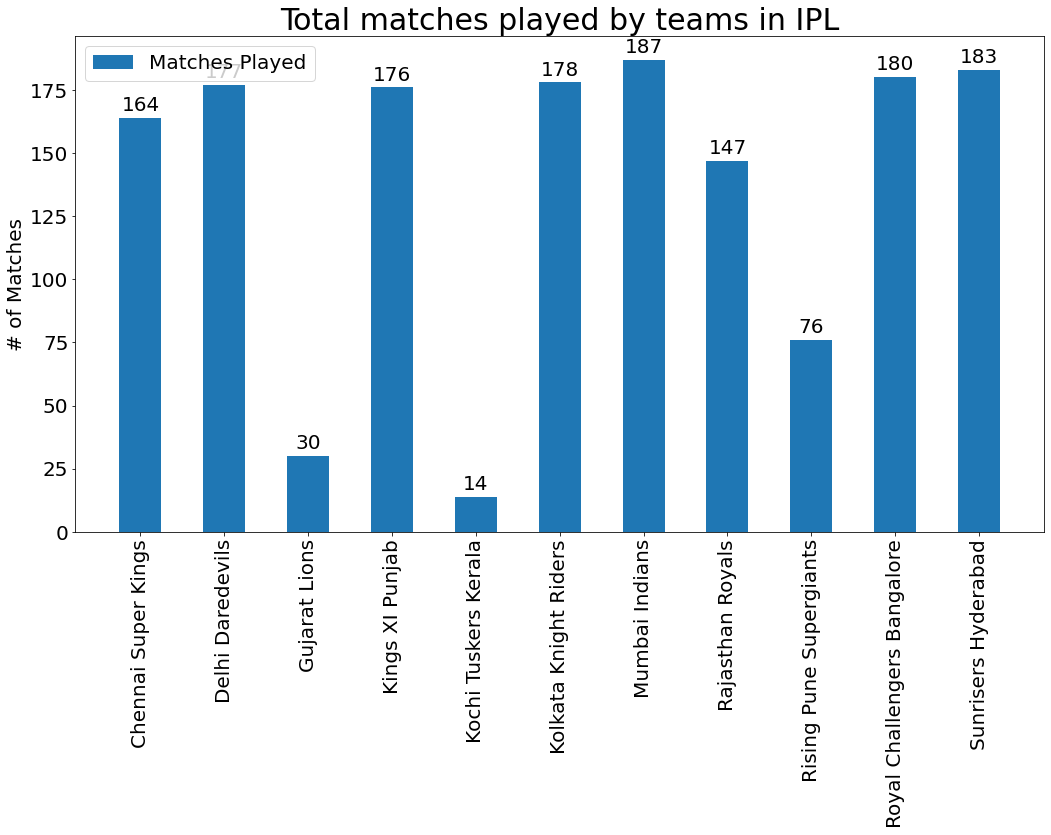

In [24]:
x = np.arange(len(all_teams))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize = (15,12))
rects1 = ax.bar(x, total_matches_played, width, label='Matches Played')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of Matches')
ax.set_title('Total matches played by teams in IPL')
ax.set_xticks(x)
ax.set_xticklabels(all_teams, rotation = 90)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('axes', titlesize=30, labelsize=20)
plt.rc('font', size=20)
autolabel(rects1)
fig.tight_layout()
plt.show()

In [25]:
#now lets calculate the win percentage
win_percentage = np.round((winners/total_matches_played)*100, decimals= 2)
#removing No result matches from winners data as it will not have any effect on calculation on win %age
win_percentage= win_percentage.drop('No result')

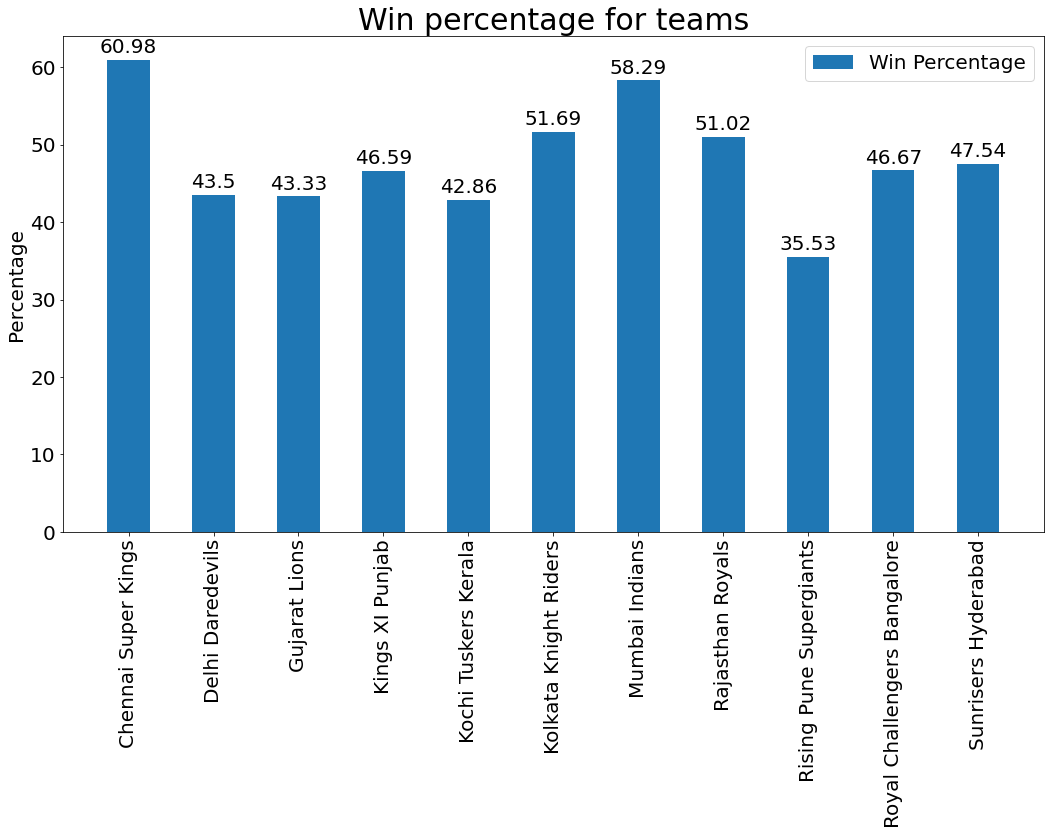

In [26]:
#creating a pie chart to visualize the data
x = np.arange(len(all_teams))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize = (15,12))
rects1 = ax.bar(x, win_percentage, width, label='Win Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Win percentage for teams')
ax.set_xticks(x)
ax.set_xticklabels(all_teams, rotation= 90)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('axes', titlesize=30, labelsize=20)
plt.rc('font', size=20)
autolabel(rects1)
fig.tight_layout()
plt.show()

Clearly Chennai Super kings have best win percentage followed by mumbai Indians. These two are clear winners here and can be called as the most consistent performers in IPL. 3rd and 4th teams in terms of win percentage are KKR and RR. 

Now lets try and answer the second question, effect of toss on the result of an IPL game.


In [27]:
#we will create one more column called toss_effect and assign 0 as value for all rows.
matches_df['toss_effect'] = 0
matches_df.head()

,id,season,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,toss_effect
59,60,2008,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,0
60,61,2008,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0
61,62,2008,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,0
62,63,2008,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,0
63,64,2008,2008-04-20,Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,0


now we will fill the toss_effect column with 1 if winning team won the toss and with 0 if they loose.

In [29]:
#Lets check toss effects outcome of the game
for i in matches_df.index:
    if matches_df['toss_winner'][i] == matches_df['winner'][i]:
        matches_df['toss_effect'][i] = 1
matches_df.head()

<ipython-input-29-91ec0cf0512c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_df['toss_effect'][i] = 1


,id,season,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,toss_effect
59,60,2008,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,0
60,61,2008,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",1
61,62,2008,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,0
62,63,2008,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,0
63,64,2008,2008-04-20,Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,0


Lets understand the effect of toss in each season. We will graph the win percentage of teams winning toss.

In [31]:
toss =matches_df.groupby(['season'])['toss_effect'].sum()
matches = matches_df.groupby(['season'])['season'].count()
toss_winner_win_percentage = np.round((toss/matches)*100, decimals = 1 )
toss_winner_win_percentage

season
2008    48.3
2009    57.9
2010    51.7
2011    52.1
2012    44.6
2013    47.4
2014    50.0
2015    47.5
2016    56.7
2017    57.6
2018    53.3
2019    60.0
dtype: float64

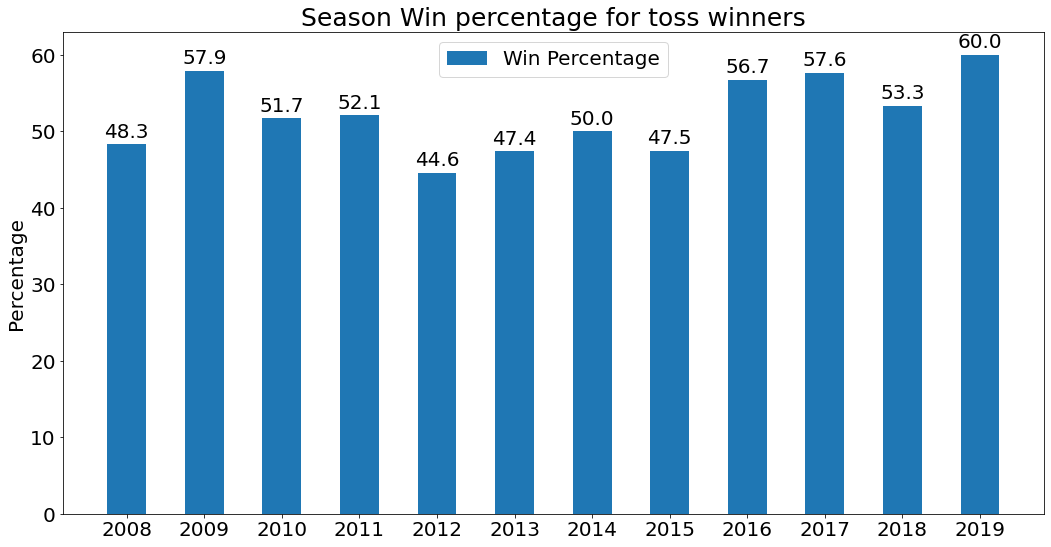

In [39]:
label2= np.arange(2008, 2020, 1)
x = np.arange(len(label2))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize = (15,8))
rects1 = ax.bar(x, toss_winner_win_percentage, width, label='Win Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Season Win percentage for toss winners')
ax.set_xticks(x)
ax.set_xticklabels(label2)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('axes', titlesize=25, labelsize=20)
plt.rc('font', size=20)
autolabel(rects1)
fig.tight_layout()
plt.show()

#We can see there is not much effect of toss, in most of the seasons result is only around 50% in favour of toss winner. But we have seen how much emphasis is given to toss in match anasysis and team planning.  Now lets check if any specific team performs well after winning the toss.

In [40]:
team_toss_wins= matches_df.groupby('toss_winner')['toss_winner'].count()
team_toss_wins

toss_winner
Chennai Super Kings            89
Delhi Daredevils               90
Gujarat Lions                  15
Kings XI Punjab                81
Kochi Tuskers Kerala            8
Kolkata Knight Riders          92
Mumbai Indians                 98
Rajasthan Royals               80
Rising Pune Supergiants        33
Royal Challengers Bangalore    81
Sunrisers Hyderabad            89
Name: toss_winner, dtype: int64

In [42]:
team_toss_match_wins = matches_df.groupby('toss_winner')['toss_effect'].sum()
team_toss_match_wins

toss_winner
Chennai Super Kings            57
Delhi Daredevils               42
Gujarat Lions                  10
Kings XI Punjab                35
Kochi Tuskers Kerala            4
Kolkata Knight Riders          53
Mumbai Indians                 56
Rajasthan Royals               42
Rising Pune Supergiants        11
Royal Challengers Bangalore    41
Sunrisers Hyderabad            42
Name: toss_effect, dtype: int64

In [43]:
match_toss_win_percen = np.round((team_toss_match_wins/team_toss_wins)*100, decimals = 2)
match_toss_win_percen

toss_winner
Chennai Super Kings            64.04
Delhi Daredevils               46.67
Gujarat Lions                  66.67
Kings XI Punjab                43.21
Kochi Tuskers Kerala           50.00
Kolkata Knight Riders          57.61
Mumbai Indians                 57.14
Rajasthan Royals               52.50
Rising Pune Supergiants        33.33
Royal Challengers Bangalore    50.62
Sunrisers Hyderabad            47.19
dtype: float64

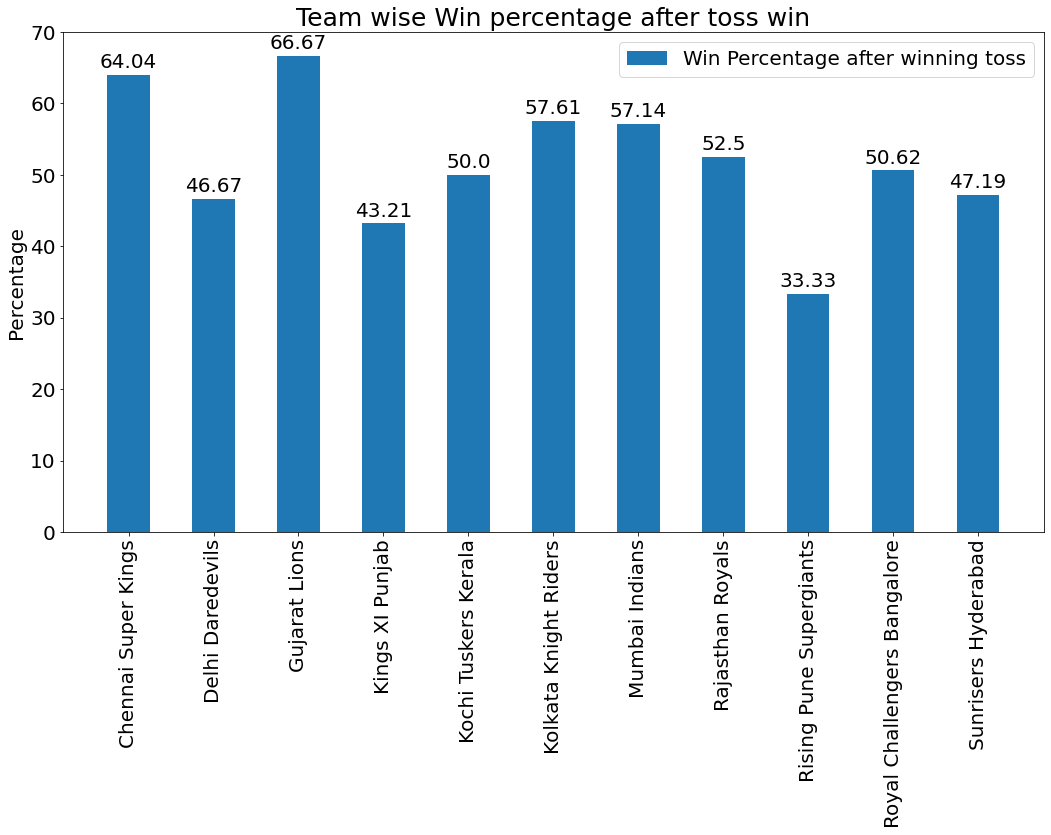

In [45]:
x = np.arange(len(all_teams))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize = (15,12))
rects1 = ax.bar(x, match_toss_win_percen, width, label='Win Percentage after winning toss')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Team wise Win percentage after toss win')
ax.set_xticks(x)
ax.set_xticklabels(all_teams, rotation = 90)
ax.legend()
plt.rc('axes', titlesize=25, labelsize=20)
plt.rc('font', size=20)
autolabel(rects1)
fig.tight_layout()
plt.show()

Clearly teams like Chennai Super Kings, Kolkata Knight Riders and Mumbai Indians have better win percentage when they win toss. This gives you an edge over other teams in knockout stages where win or loss can eliminate other team and make you finalist or even champian. Gujrat Loins is clearly a leader in this category but given it has played only 2 seasons we are choosing to ignore this franchise.

Now coming to the final question of which overs are best to score runs and to take wickets. We will start with deliveries data.

In [46]:
deliveries_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,N/A,N/A,N/A
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,N/A,N/A,N/A
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,N/A,N/A,N/A
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,N/A,N/A,N/A
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,N/A,N/A,N/A


lets draw a graph showing on avergae how many runs were scored in 20 overs and 2 innings  

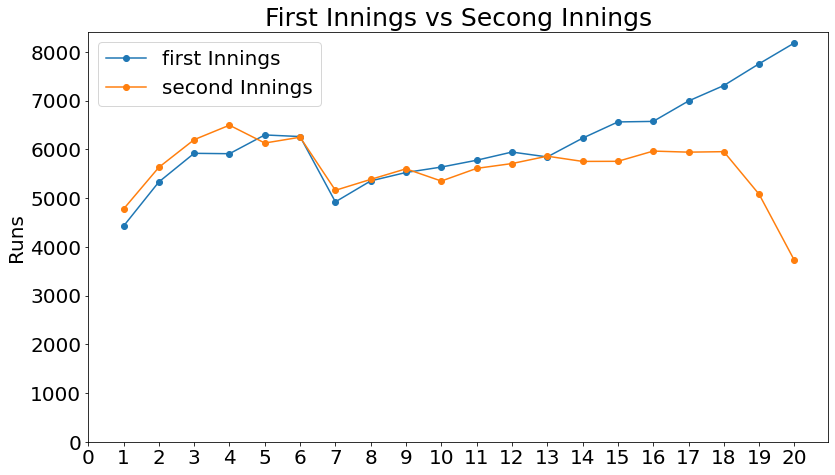

In [48]:
labels = np.arange(0, 21, 1)
over_runs = deliveries_df.groupby(['inning', 'over'])['total_runs'].sum()
inning1 = over_runs[1]
inning2 = over_runs[2]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize = (12,7))
rects1 = ax1.plot(inning1,marker = 'o', label='first Innings')
rects2 = ax1.plot(inning2, marker= 'o', label='second Innings')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Runs')
ax1.set_title('First Innings vs Secong Innings')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
ax1.set_ylim(0)

fig.tight_layout()
plt.show()

we can see that most number of runs are scored in first 6 overs. team batting first score most runs in last 5 overs which is not the case for team batting second(downtrend in last 2 overs can be attributed to the fact that team batting second might winn game early and not play the whole 20 overs.)

Now lets draw a chart of total number of wickets fall in each of 20 overs and 2 innings in lsat 12 seasons. We will do this by creating a new data frame wickets_df which will have entries where wickets fell(we will identify the row by comparing the row data with N/A, which we imputed earlier for all the empty rows in player_dismissed column)

In [49]:
ind = list()
for i in deliveries_df.index:
    if deliveries_df['player_dismissed'][i] != 'N/A':
        ind.append(i)

wickets_df = deliveries_df.loc[ind, :]
    

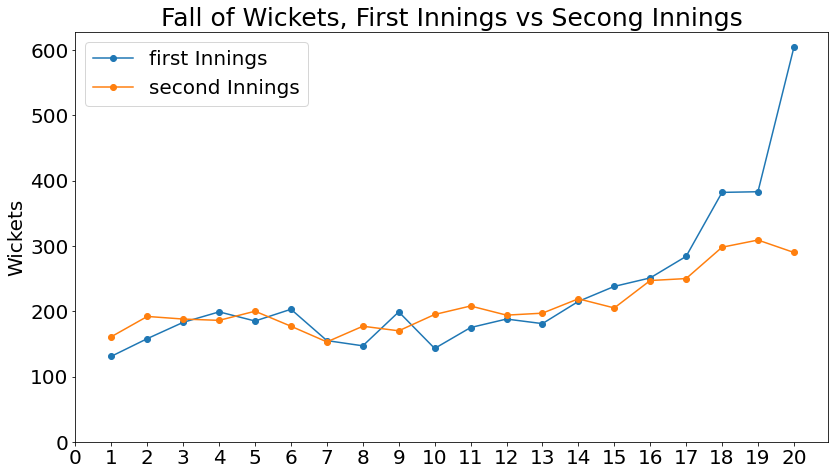

In [50]:
labels = np.arange(0, 21, 1)
wickets = wickets_df.groupby(['inning', 'over'])['player_dismissed'].count()
inning1 = wickets[1]
inning2 = wickets[2]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (12,7))
rects1 = ax.plot(inning1,marker = 'o', label='first Innings')
rects2 = ax.plot(inning2, marker= 'o', label='second Innings')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Wickets')
ax.set_title('Fall of Wickets, First Innings vs Secong Innings')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0)

fig.tight_layout()
plt.show()

We can see that the team batting first scores less runs in first 10 overs and then explodes in the final 10 overs, specially in last 5 overs where most number of runs are scored. Contrasting pattern can be seen for team batting second, they try and score more runs from the start and getting most number of runs in first 6 overs. The decline in last two overs can be attributed to teams batting second might finish the game early and hence number of runs scored in these overs are comparatively less. We can clearly see that both team try to score more runs during the power play specially 3rd,4th and 5th overs of the power play.